In [2]:
import sys, os
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from scipy.stats import randint as sp_randint
from sklearn import svm
from time import time
from operator import itemgetter
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/home/kevin/anaconda3/envs/ML/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/kevin/anaconda3/envs/ML/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
trainingSetDir = "/home/kevin/LOTTERHOS_LAB/TTT_RecombinationGenomeScans/ml_project/testVecs"

In [4]:
classifierPickleFileName = "QTNdistinct.p"
statsToUse = "all"
classList = []
trainingData = []
labelToClassName = {}
headerH = {}

for trainingSetFileName in os.listdir(trainingSetDir):
    classList.append(trainingSetFileName.split(".fvec")[0])
    trainingSetFile = open(trainingSetDir + "/" + trainingSetFileName)
    currTrainingData = trainingSetFile.readlines()
    trainingSetFile.close()

    trainingData += currTrainingData[1:]#append all training data from the current set (minus the header)

    currLabelH = {}
    for example in currTrainingData[1:]:
        currLabelH[example.split("\t")[0]] = 1
    assert len(currLabelH) == 1
    labelToClassName[currLabelH.keys()[0]] = trainingSetFileName.split(".fvec")[0]
    
    header = currTrainingData[0].strip().split("\t")
    headerH[currTrainingData[0].strip()] = 1
    assert header[0] == "classLabel"
    statIndices = []
    if "all" in statsToUse:
        statIndices = range(1, len(header))
    else:
        for i in range(1, len(header)):
            if header[i] in statsToUse or header[i].split("_win")[0] in statsToUse:
                statIndices.append(i)
assert len(headerH) == 1

sys.stderr.write("using these features: %s (indices: %s)\n" %(str(statsToUse), str(statIndices)))
XH = {}
for i in range(len(trainingData)):
    trainingData[i] = trainingData[i].strip().split("\t")
    currVector = []
    if not "nan" in trainingData[i]:
        for j in statIndices:
            currVector.append(float(trainingData[i][j]))
        assert len(currVector) == len(statIndices)
        if not XH.has_key(trainingData[i][0]):
            XH[trainingData[i][0]] = []
        XH[trainingData[i][0]].append(currVector)

using these features: all (indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


In [5]:
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
#balance the training set
# minClassSize = min([len(XH[classLabel]) for classLabel in  XH.keys()])
X = []
y = []
for classLabel in sorted(XH.keys()):
    print('{:24} : {:>6}'.format(classLabel, str(len(XH[classLabel]))))
    random.shuffle(XH[classLabel])
    for i in range(1000):
        try:
            currVector = XH[classLabel][i]
        except IndexError:
            break
        X.append(currVector)
        y.append(classLabel)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
sys.stderr.write("Training set size after split: %s\n" %(len(y_train)))
sys.stderr.write("Testing set size: %s\n" %len(y_test))

#SMOTE:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
sys.stderr.write("training set size after balancing: %s\n" %(len(y_resampled)))

MT=delet_R=BS            :    379
MT=lgQTN_R=lgQTNlink     :     86
MT=neut_R=BS             :  31197
MT=neut_R=FarSS          :    585
MT=neut_R=NearSS         :    983
MT=neut_R=invers         :  11920
MT=neut_R=lgQTNlink      :    502
MT=neut_R=lowRC          :   8644
MT=neut_R=neutral        : 312608
MT=neut_R=smQTNlink      :   3511
MT=smQTN_R=smQTNlink     :    639
MT=sweep_R=NearSS        :     53


Training set size after split: 6170
Testing set size: 2057
training set size after balancing: 9204


In [15]:
print(XH.keys())
labels = XH.keys()

['MT=neut_R=smQTNlink', 'MT=neut_R=NearSS', 'MT=neut_R=lgQTNlink', 'MT=neut_R=BS', 'MT=neut_R=invers', 'MT=neut_R=lowRC', 'MT=QTN_R=neutral', 'MT=delet_R=BS', 'MT=neut_R=neutral', 'MT=sweep_R=NearSS', 'MT=neut_R=FarSS']


In [10]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [11]:
sys.stderr.write("Checking accuracy when distinguishing among all %s classes\n" %(len(XH.keys())))

maxMaxFeatures = len(X[0])
param_grid_forest = {"max_depth": [3, 10, None],
              "max_features": [1, 3, int(maxMaxFeatures**0.5), maxMaxFeatures],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

clf, mlType, paramGrid = ExtraTreesClassifier(n_estimators=100), "extraTreesClassifier", param_grid_forest

heatmap = []
sys.stderr.write("Training %s\n" %(mlType))
grid_search = GridSearchCV(clf,param_grid=param_grid_forest,cv=10,n_jobs=-1)
start = time()
grid_search.fit(X_resampled, y_resampled)
sys.stderr.write("GridSearchCV took %.2f seconds for %d candidate parameter settings.\n"
      % (time() - start, len(grid_search.grid_scores_)))
print "Results for %s" %(mlType)
report(grid_search.grid_scores_)
joblib.dump((X_test, y_test, grid_search, XH.keys()), classifierPickleFileName)

Checking accuracy when distinguishing among all 12 classes
Training extraTreesClassifier
GridSearchCV took 1144.47 seconds for 432 candidate parameter settings.


Results for extraTreesClassifier
Model with rank: 1
Mean validation score: 0.691 (std: 0.041)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'entropy', 'max_features': 15, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.691 (std: 0.048)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 3, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.691 (std: 0.037)
Parameters: {'bootstrap': False, 'min_samples_leaf': 1, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 15, 'max_depth': None}



['QTNdistinct.p']

Testing the best classifier, printing confusion matrix


Confusion matrix, without normalization
[[ 69  54   8   4   0   0   6   0  71  37  11   4]
 [ 44  74  17  31   1   0   1   0  41  28   0   3]
 [  9  21  46  31   8   0   0   0   9   8   1   0]
 [ 15  25  23  68   6   0   0   0  11   9   3   1]
 [  0   0   6   5   8   0   0   0   0   0   0   0]
 [  0   1   1   0   0 143  68  17   1   1  21   0]
 [  4   0   0   0   0  59  47   2   5   3  25   0]
 [  0   0   0   0   0   8   1   5   0   0   0   0]
 [ 72  23   7   3   0   1   5   0  78  34  10   3]
 [ 22   9   6   5   0   0   0   0  28  25   6   8]
 [  0   0   0   1   0  15  16   0   1   4 190   6]
 [  5   2   2   1   0   0   0   0  14  15  19 192]]


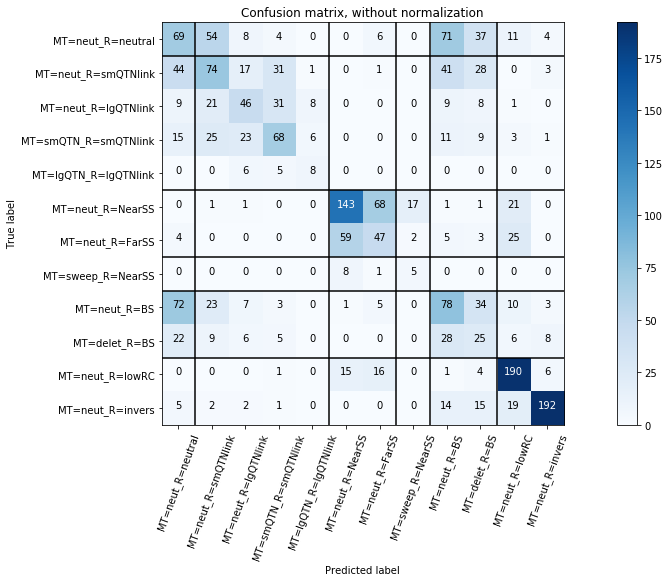

Normalized confusion matrix
[[0.26 0.2  0.03 0.02 0.   0.   0.02 0.   0.27 0.14 0.04 0.02]
 [0.18 0.31 0.07 0.13 0.   0.   0.   0.   0.17 0.12 0.   0.01]
 [0.07 0.16 0.35 0.23 0.06 0.   0.   0.   0.07 0.06 0.01 0.  ]
 [0.09 0.16 0.14 0.42 0.04 0.   0.   0.   0.07 0.06 0.02 0.01]
 [0.   0.   0.32 0.26 0.42 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.57 0.27 0.07 0.   0.   0.08 0.  ]
 [0.03 0.   0.   0.   0.   0.41 0.32 0.01 0.03 0.02 0.17 0.  ]
 [0.   0.   0.   0.   0.   0.57 0.07 0.36 0.   0.   0.   0.  ]
 [0.31 0.1  0.03 0.01 0.   0.   0.02 0.   0.33 0.14 0.04 0.01]
 [0.2  0.08 0.06 0.05 0.   0.   0.   0.   0.26 0.23 0.06 0.07]
 [0.   0.   0.   0.   0.   0.06 0.07 0.   0.   0.02 0.82 0.03]
 [0.02 0.01 0.01 0.   0.   0.   0.   0.   0.06 0.06 0.08 0.77]]


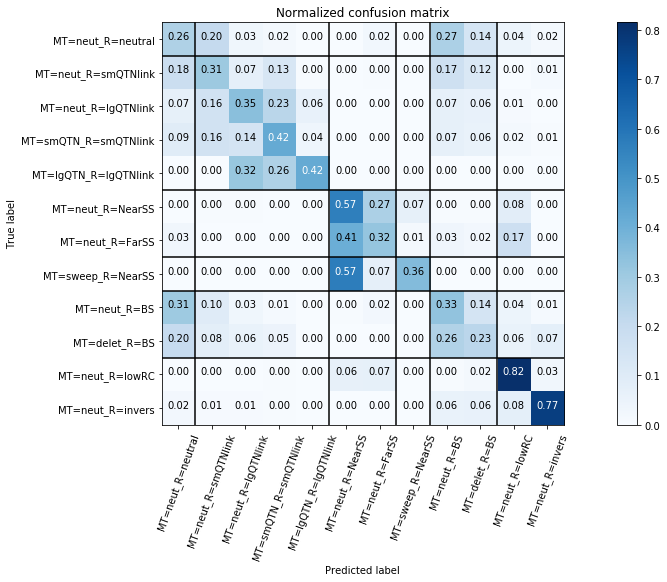

                      precision    recall  f1-score   support

       MT=delet_R=BS       0.15      0.23      0.18       109
MT=lgQTN_R=lgQTNlink       0.35      0.42      0.38        19
        MT=neut_R=BS       0.30      0.33      0.32       236
     MT=neut_R=FarSS       0.33      0.32      0.33       145
    MT=neut_R=NearSS       0.63      0.57      0.60       253
    MT=neut_R=invers       0.88      0.77      0.82       250
 MT=neut_R=lgQTNlink       0.40      0.35      0.37       133
     MT=neut_R=lowRC       0.66      0.82      0.73       233
   MT=neut_R=neutral       0.29      0.26      0.27       264
 MT=neut_R=smQTNlink       0.35      0.31      0.33       240
MT=smQTN_R=smQTNlink       0.46      0.42      0.44       161
   MT=sweep_R=NearSS       0.21      0.36      0.26        14

         avg / total       0.47      0.46      0.46      2057



In [16]:
plotReportForComparison("QTNdistinct.p")